In [19]:
#funzione per estrarre i dati dal file txt
def importa_dati(s):
    
    #apro il file relativo all'ECG che si trova all'indirizzo passato 
    #leggo il file e lo salvo come stringa nella variabile ecg (era un file .txt)
    #"r"=lettura
    ecg=open(s,"r").read()
    
    #verifico che in effetti si tratta di una stringa
    tipo=type(ecg)
    
    #con la funzione split implementata in Phyton per le stringhe trovo tutti i separatori e ad
    #ogni separatore spezzo 
    #salvo il tutto in una lista(array) che per ora è ancora una lista di stringhe

    ecg1=ecg.split()
    
    #voglio distinguere i numeri dei campioni per poterli plottare sull'asse x e i valori per
    #plottarli sull'asse y
    #inizializzo due liste vuote,una per la x una per la y

    num_campioni=[]
    valori=[]
    
    #i valori pari della lista ecg1 mi rappresentano il numero di campione, quelli dispari il
    #valore correlato al singolo campione
    #quando l'indice è pari salvo il valore nella lista num_campioni,altrimenti lo  salvo nella
    #lista valori
    #notare la conversione a int e float

    for i in range(len(ecg1)):
        if i%2==0:
            num_campioni.append(int(ecg1[i]))
        else:
            valori.append(float(ecg1[i]))
            
    return num_campioni,valori


In [20]:
#parte di codice per stampare i grafici dei segnali
#richiamo le librerie utili: numpy per successivi utilizzi e matplotlib.pyplot per i grafici
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def stampa_segnale(x,y,titolo,inf,sup,n):
    
    #plotto il numero di campione su x e il corrispondente valore su y
    plt.plot(x,y)
    plt.axis([0,n,inf,sup])
    plt.xlabel("numero campione [n]")
    plt.ylabel("ampiezza [mV]")
    plt.title(titolo)
    plt.grid()
    

In [21]:
#funzioni che implementano filtri
#importo il modulo signal di scipy per l'analisi di segnale
import scipy.signal as signal

#Creo filtro passa banda con frequenza di taglio 5-15 Hz, è un filtro FIR che ha fase lineare
#ne disegno la risposta in frequenza
#questo filtro introduce un ritardo di 19 campioni
#la funzione riceve in ingresso la freq di campionamento e restituisce i coeff del numeratore
#e denominatore del filtro(b,a)

def filtro_passabanda(fs,f1,f2):
    b=signal.firwin(20, [f1*2/fs, f2*2/fs], pass_zero=False)
    w,h=signal.freqz(b)
    plt.plot(fs*w/np.pi,np.abs(h),'r')
    plt.axis([0.1,fs/2,-1,5])
    plt.xlabel("frequenza[Hz]")
    plt.ylabel("ampiezza")
    plt.title("Modulo del filtro passa-banda")
    plt.grid()
    plt.show()
        
    return b

In [22]:
#funzione che applica un filtro:
def applica_filtro(b,a,valori):
    output=signal.lfilter(b, a, valori)
    return output

In [23]:
#chiedo all'utente il file da analizzare e lo passo alla funzione estrai_dati come stringa
#ricevo dalla funzione il vettore dei campioni e delle ampiezze

print("Inserire il nome del file da analizzare")
s=input()
print("Inserire il nome del grafico")
s1=input()
campioni,ampiezze=importa_dati(s)


Inserire il nome del file da analizzare
C:\Users\Serena\Desktop\ecgiddb_ECG1.txt
Inserire il nome del grafico
Segnale iniziale


Inserire la frequenza di campionamento
500


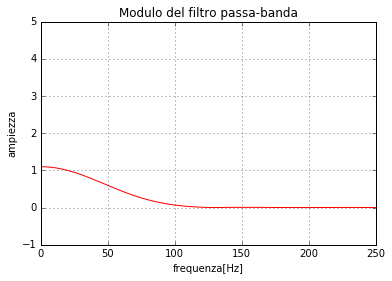

In [24]:
#disegno i filtri e li applico: passabanda, derivatore, elevo al quadrato e media mobile
#prendo in input la frequenza di campionamento


print("Inserire la frequenza di campionamento")
fs=int(input())

#passabanda per limitare il SNR
#creo due liste vuote ceh trasformo in array di numpy, perchè la funzione filtro_pasabanda
#mi restituisce due array numpy
n=[]
n=np.ndarray(n)
n=filtro_passabanda(fs,5,15)
output1=applica_filtro(n,1,ampiezze)



#filtro derivatore:prendo i coefficienti dall'algoritmo di Pan-Tompkins
#l'inizializzazione del filtro richiede N-1 campioni (in questo caso 4), per questo devo
#allungare il vettore num_campioni
#mi serve per evidenziare la parte di segnale con maggior pendenza
h_d= [-1/8,-2/8,0,2/8,1/8]
output2= signal.convolve(output1,h_d)

n=len(campioni)
campioni2=[]
for i in range(len(campioni)):
    campioni2.append(campioni[i])

for i in range(len(output2)- n):
    campioni2.append(n+i)



#Elevo al quadrato (raddrizzamento):
output3=[0 for i in range(len(output2))]

for i in range(len(output2)):
    output3[i]=output2[i]**2
    
#filtro a media mobile
#abbiamo ignorato i primi N-1 campioni perchè costituiscono l'inizializzazione del filtro
#e quindi non danno info utili
N=25
output4=[0]*len(output3)

for n in range(N-1,len(output3)):
    for i in range(N-1):
        output4[n]=output4[n]+output3[n-i]
    output4[n]=output4[n]/N  







In [25]:
#Posizione dei picchi R: partendo dall'inizio del segnale tramite il for identifichiamo il
#primo campione sopra la soglia (inizios) e poi il primo campione che torna sotto la soglia
#(fines). In questo intervallo calcoliamo il massimo valore assunto dal segnale e questo
#corrisponde al picco R. Ripetiamo l'operazione più volte spostandoci 
#sul segnale e identifiando tutti i massimi e salvandoli nell'array m
fines=0
ok=1
m=[]

while(ok):
    for i in range(fines,len(output4)):
        if(i==len(output4)-200):
            ok=0
        if(output4[i]>=0.00015):
            inizios=i
            break
    for i in range(inizios,len(output4)):
        if(output4[i]<=0.00015):
            fines=i
            break
    m.append(inizios+np.argmax(output4[inizios:fines]))
    
print(m)

#costruiamo due altri array che identificano rispetivamente: m1 la posizione dei picchi nel
#segnale filtrato passa-banda, m2 la posizione dei picchi nel segnale dopo la derivazione
#I numeri 24 e 28 sono relativi ai campioni di ritardo introdotti dai filtri: 24 campioni
#per la media mobile e 4 per il filtro derivativo
m1=[]
m2=[]
m3=[]

for i in m:
    m1.append(i-28)
    m2.append(i-24)
    m3.append(i-47)
    

[374, 749, 1156, 1621, 2088, 2547, 3014, 3458, 3892, 4315, 4729, 5140, 5519, 5887, 6246, 6609, 6981, 7369, 7757, 8158, 8567, 8994, 9418, 9846]


Quanti campioni vuoi visualizzare?
2000
numero del segnale?
1


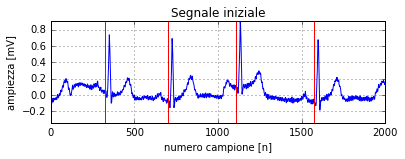

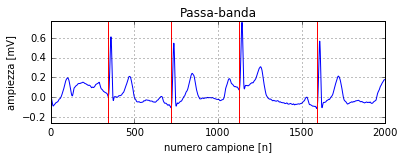

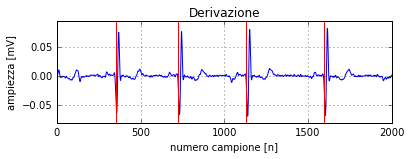

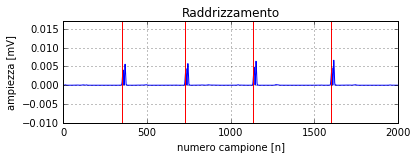

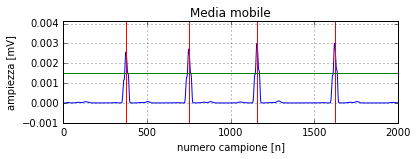

In [26]:
#disegniamo i grafici di vari passaggi per arrivare alla detezione dei picchi R
print("Quanti campioni vuoi visualizzare?")
c=int(input())
print("numero del segnale?")
num=int(input())


#grafico inziale
plt.figure(1)
plt.subplot(2,1,1)
stampa_segnale(campioni,ampiezze,s1,min(ampiezze)-0.01,(max(ampiezze)+0.01),c)
plt.plot([m3,m3],[max(ampiezze)+0.01,min(ampiezze)-0.01],'r')
plt.savefig("segnale iniziale_"+str(num))
plt.show()



plt.figure(2)
plt.subplot(2,1,1)
stampa_segnale(campioni,output1,"Passa-banda",min(output1)-0.01,(max(output1)+0.01),c)
plt.plot([m1,m1],[min(output1)-0.01,(max(output1)+0.01)],'r')
plt.savefig("output1_"+str(num))
plt.show()


plt.figure(3)
plt.subplot(2,1,1)
stampa_segnale(campioni2,output2,"Derivazione",min(output2)-0.01,(max(output2)+0.01),c)
plt.plot([m2,m2],[min(output2)-0.01,(max(output2)+0.01)],'r')
plt.savefig("output2_"+str(num))
plt.show()


plt.figure(4)
plt.subplot(2,1,1)
stampa_segnale(campioni2,output3,"Raddrizzamento",min(output3)-0.01,(max(output3)+0.01),c)
plt.plot([m2,m2],[min(output3)-0.01,(max(output3)+0.01)],'r')
plt.savefig("output3_"+str(num))
plt.show()


plt.figure(5)
plt.subplot(2,1,1)
stampa_segnale(campioni2,output4,"Media mobile",min(output4)-0.001,(max(output4)+0.001),c)
plt.plot([0,c],[0.0015,0.0015],'g')
plt.plot([inizios,inizios],[min(output4)-0.001,(max(output4)+0.001)],'g')
plt.plot([fines,fines],[min(output4)-0.001,(max(output4)+0.001)],'g')
plt.plot([m,m],[min(output4)-0.001,(max(output4)+0.001)],'r')
plt.savefig("output4_"+str(num))
plt.show()





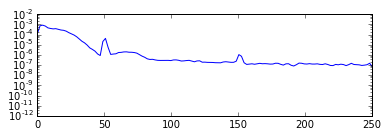

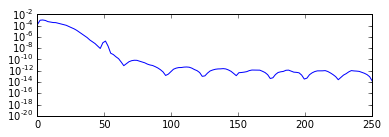

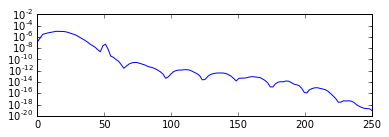

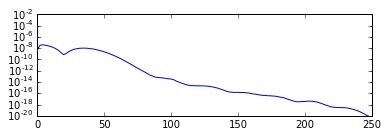

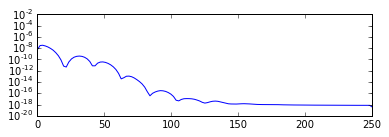

In [27]:
#Spettri di potenza con il metodo di Welch
plt.figure(1)
plt.subplot(2,1,1)
p1,p2=signal.welch(ampiezze,fs)
plt.semilogy(p1,p2)
plt.axis([0,fs/2,10**(-12),10**(-2)])
plt.show()


plt.figure(2)
plt.subplot(2,1,1)
p1,p2=signal.welch(output1,fs)
plt.semilogy(p1,p2)
plt.axis([0,fs/2,10**(-20),10**(-2)])
plt.show()

plt.figure(3)
plt.subplot(2,1,1)
p1,p2=signal.welch(output2,fs)
plt.semilogy(p1,p2)
plt.axis([0,fs/2,10**(-20),10**(-2)])
plt.show()

plt.figure(4)
plt.subplot(2,1,1)
p1,p2=signal.welch(output3,fs)
plt.semilogy(p1,p2)
plt.axis([0,fs/2,10**(-20),10**(-2)])
plt.show()

plt.figure(5)
plt.subplot(2,1,1)
p1,p2=signal.welch(output4,fs)
plt.semilogy(p1,p2)
plt.axis([0,fs/2,10**(-20),10**(-2)])
plt.show()


In [28]:
#salviamo gli array come file testo
np.savetxt("output1_"+str(num)+".txt",output1)
np.savetxt("output2_"+str(num)+".txt",output2)
np.savetxt("output3_"+str(num)+".txt",output3)
np.savetxt("output4_"+str(num)+".txt",output4)

[80.0, 73.710073710073715, 64.516129032258064, 64.239828693790145, 65.359477124183002, 64.239828693790145, 67.567567567567565, 69.124423963133637, 70.921985815602838, 72.463768115942031, 72.992700729927009, 79.155672823218993, 81.521739130434781, 83.565459610027858, 82.644628099173559, 80.645161290322577, 77.319587628865975, 77.319587628865975, 74.812967581047388, 73.349633251833737, 70.257611241217802, 70.754716981132077, 70.09345794392523]


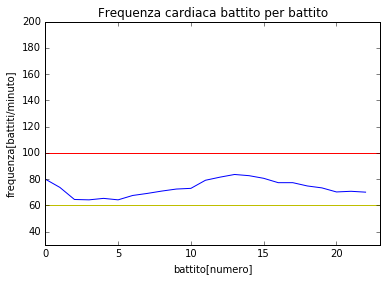

La frequenza media è: 73.3293915938
Frequenza regolare


In [18]:
#calcolo la frequenza cardiaca battito per battito

hf=[]
for i in range(len(m2)-1):
    hf.append(fs*60/(m2[i+1]-m2[i]))

print(hf)
    

#disegno il grafico e le soglie di tachicardia,bradicardia e il valore medio della popolazione
x=[x for x in range(len(hf))]
plt.plot(x,hf)
plt.plot([0,len(hf)],[60,60],'y')
plt.plot([0,len(hf)],[100,100],'r')
plt.axis([0,len(hf),30,200])
plt.title("Frequenza cardiaca battito per battito")
plt.xlabel("battito[numero]")
plt.ylabel("frequenza[battiti/minuto]")
plt.savefig("frequenza_"+str(num))
plt.show()

freq_media=np.mean(hf)
print("La frequenza media è: "+str(freq_media))

if(freq_media<60):
    print("Sei bradicardico!!")
elif(freq_media>100):
    print("Sei tachicardico!!")
else:
    print("Frequenza regolare")